In [1]:
import numpy as np
import pandas as pd
import pydicom
%matplotlib inline
import matplotlib.pyplot as plt
import keras 

from skimage.transform import resize

Using TensorFlow backend.


In [2]:
# This function reads in a .dcm file, checks the important fields for our device, and returns a numpy array
# of just the imaging data
def check_dicom(filename): 
    print('Load file {} ...'.format(filename))
    ds = pydicom.dcmread(filename)
    
    print(f"body = {ds.BodyPartExamined}, patient pos = {ds.PatientPosition}, modality = {ds.Modality}")
    if ('chest' in ds.BodyPartExamined.lower()) and \
       (ds.PatientPosition.lower() in ['ap', 'pa']) and \
       (ds.Modality == 'DX'):
        img = ds.pixel_array
    else:
        img = None
    return img
    
    
# This function takes the numpy array output by check_dicom and 
# runs the appropriate pre-processing needed for our model input
def preprocess_image(img,img_mean,img_std,img_size):
    # new_img = (img.copy() - img_mean) / img_std
    new_img = img.copy() * 1.0 / 255.0
    proc_img = resize(new_img, img_size, anti_aliasing=True)
    
    return proc_img

# This function loads in our trained model w/ weights and compiles it 
def load_model(model_path, weight_path):
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()

    model = keras.models.model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(weight_path)
    
    return model

# This function uses our device's threshold parameters to predict whether or not
# the image shows the presence of pneumonia using our trained model
def predict_image(model, img, thresh): 
    pred_Y = model.predict(img)
    prediction = pred_Y > thresh
    
    return prediction 

Load file test1.dcm ...
body = CHEST, patient pos = PA, modality = DX
Processed
[[ True]]
Load file test2.dcm ...
body = CHEST, patient pos = AP, modality = DX
Processed
[[ True]]
Load file test3.dcm ...
body = CHEST, patient pos = AP, modality = DX
Processed
[[ True]]
Load file test4.dcm ...
body = RIBCAGE, patient pos = PA, modality = DX
Load file test5.dcm ...
body = CHEST, patient pos = PA, modality = CT
Load file test6.dcm ...
body = CHEST, patient pos = XX, modality = DX


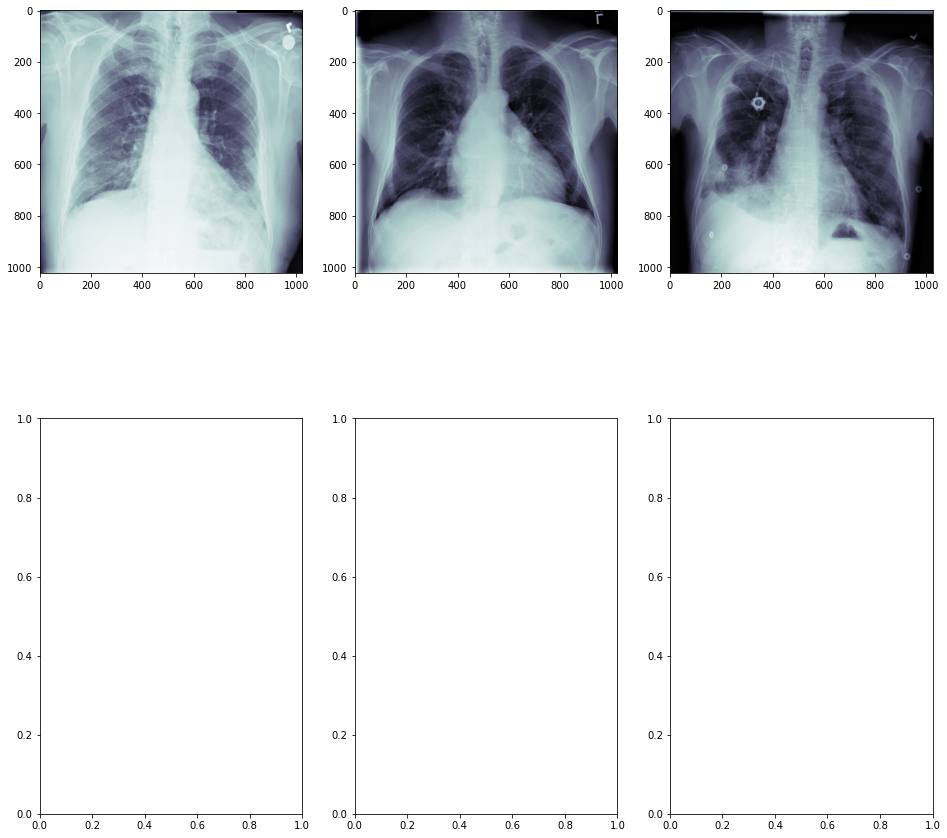

In [3]:
test_dicoms = ['test1.dcm','test2.dcm','test3.dcm','test4.dcm','test5.dcm','test6.dcm']

model_path = 'my_model.json'
weight_path = 'xray_class_my_model.best.hdf5'

IMG_SIZE=(1,224,224,3) # This might be different if you did not use vgg16
img_mean = 0 # loads the mean image value they used during training preprocessing
img_std = 1 # loads the std dev image value they used during training preprocessing

my_model = load_model(model_path, weight_path) #loads model
thresh = 0.3 #loads the threshold they chose for model classification 

# use the .dcm files to test your prediction
fig, m_axs = plt.subplots(2, 3, figsize = (16, 16))

for (i, c_ax) in zip(test_dicoms, m_axs.flatten()):
   
    img = np.array([])
    img = check_dicom(i)
    
    if img is None:
        continue
        
    img_proc = preprocess_image(img,img_mean,img_std,IMG_SIZE)
    
    print('Processed')
    c_ax.imshow(img, cmap='bone')
    pred = predict_image(my_model,img_proc,thresh)
    print(pred)